# Persiapan Training

## Cek apakah terdapat nvcc dan gcc

In [1]:
#Catatan: Jika NVCC/GCC tidak terdeteksi maka proses training tidak akan berjalan!

# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0
gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Import Library

Library Dasar

In [2]:
from mmcv import collect_env
collect_env()

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


0.3.4
2.28.2
10.2
GCC 7.3


/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Library Tambahan

In [ ]:
import mmcv
import os
import random
import matplotlib.pyplot as plt
import os.path as osp
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector, show_result_pyplot

## Download dataset dari roboflow

In [63]:
# Versi 8
from roboflow import Roboflow
rf = Roboflow(api_key="bSj4K02UdSqagdTEh8Z5")
project = rf.workspace("lulus-vpibo").project("green-coffee-bean-defects")
version = project.version(8)
dataset = version.download("coco-mmdetection")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to green-coffee-bean-defects-8 in coco-mmdetection:: 100%|█| 368/368 [00:00<00:


## Convert dataset menjadi DOTA format

In [64]:
import os
import json
import shutil
from PIL import Image

def convert_coco_to_dota_split(coco_json_path, image_dir, output_dir):
    """
    Convert a single COCO split (train, test, or valid) to DOTA format and copy images as .png.

    Parameters:
        coco_json_path (str): Path to the COCO JSON file.
        image_dir (str): Path to the directory containing images.
        output_dir (str): Path to the output directory where DOTA annotations and images will be saved.
    """
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    label_dir = os.path.join(output_dir, 'labelTxt')
    image_output_dir = os.path.join(output_dir, 'images')
    os.makedirs(label_dir, exist_ok=True)
    os.makedirs(image_output_dir, exist_ok=True)

    # Load COCO JSON
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Map category IDs to category names
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

    # Map image IDs to filenames
    images = {img['id']: img['file_name'] for img in coco_data['images']}

    # Convert annotations
    annotations = coco_data['annotations']
    dota_annotations = {}
    for ann in annotations:
        image_id = ann['image_id']
        if image_id not in dota_annotations:
            dota_annotations[image_id] = []

        # COCO bbox format: [x_min, y_min, width, height]
        x_min, y_min, width, height = ann['bbox']
        x_max, y_max = x_min + width, y_min + height
        category_name = categories[ann['category_id']]

        # Convert to DOTA format: [x1, y1, x2, y2, x3, y3, x4, y4, category_name, difficulty]
        dota_annotations[image_id].append(
            f"{x_min} {y_min} {x_max} {y_min} {x_max} {y_max} {x_min} {y_max} {category_name} 0"
        )

    # Save DOTA annotations and copy images as .png
    for image_id, lines in dota_annotations.items():
        file_name = images[image_id]
        label_file_name = os.path.splitext(file_name)[0] + ".txt"
        label_file_path = os.path.join(label_dir, label_file_name)

        # Save annotation file
        with open(label_file_path, 'w') as f:
            f.write("\n".join(lines))

        # Copy and convert the corresponding image to .png
        src_image_path = os.path.join(image_dir, file_name)
        dst_image_name = os.path.splitext(file_name)[0] + ".png"
        dst_image_path = os.path.join(image_output_dir, dst_image_name)

        if os.path.exists(src_image_path):
            try:
                with Image.open(src_image_path) as img:
                    img.convert("RGB").save(dst_image_path, "PNG")
            except Exception as e:
                print(f"Error converting {src_image_path} to PNG: {e}")

    print(f"DOTA annotations and images saved in {output_dir}.")

def convert_coco_dataset(base_dir, output_dir):
    """
    Convert COCO dataset splits (train, test, valid) to DOTA format and copy images as .png.

    Parameters:
        base_dir (str): Path to the base directory containing COCO dataset.
        output_dir (str): Path to the base directory for DOTA output.
    """
    splits = ['train', 'test', 'valid']
    for split in splits:
        print(f"Processing {split} split...")
        coco_json_path = os.path.join(base_dir, split, '_annotations.coco.json')
        image_dir = os.path.join(base_dir, split)
        split_output_dir = os.path.join(output_dir, split)
        convert_coco_to_dota_split(coco_json_path, image_dir, split_output_dir)

# Define dataset paths
base_dir = 'green-coffee-bean-defects-8'  # Base directory of COCO dataset
output_dir = 'green-coffee-bean-defects-8-DOTA'  # Output directory for DOTA dataset

# Convert the dataset
convert_coco_dataset(base_dir, output_dir)

Processing train split...
DOTA annotations and images saved in green-coffee-bean-defects-8-DOTA/train.
Processing test split...
DOTA annotations and images saved in green-coffee-bean-defects-8-DOTA/test.
Processing valid split...
DOTA annotations and images saved in green-coffee-bean-defects-8-DOTA/valid.


## Download dataset yang sudah berformat DOTA

In [ ]:
# Belum diubah
!gdown id

## Daftarkan dataset kedalam sistem

In [6]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset

@ROTATED_DATASETS.register_module()
class CoffeeDataset(DOTADataset):
    """SAR ship dataset for detection."""
    CLASSES = ('hitam','hitam-sebagian','kulit-kopi-kecil',)

# Proses training

## Visualisasi Dataset

In [24]:
!tree manual_dataset

manual_dataset
├── images
│   ├── 30_100_jpg.rf.647d8dd9a7c152016ba9c1c36a91ae28.png
│   ├── 30_101_jpg.rf.372cb321179c9c7ddc79b51d078c070c.png
│   ├── 30_102_jpg.rf.f1868cdbb8d99faee0d089664984506f.png
│   ├── 30_103_jpg.rf.e8c3e9de8aedb9d1ec23d61dfffb8e1f.png
│   ├── 30_104_jpg.rf.4430d14ed36845c628ac18681cd19c02.png
│   ├── 30_105_jpg.rf.02f74b0455d7b2075b2a6530b43da154.png
│   ├── 30_106_jpg.rf.f4efc1d07a29d3d1f7d526c73e698040.png
│   ├── 30_107_jpg.rf.db53fd5ed4f62fc10e9a5e7a77bc1529.png
│   ├── 30_108_jpg.rf.de40f12ce4abb42c4a899cf0bbb199ea.png
│   ├── 30_109_jpg.rf.b974d487ee74106247a3a735600030ea.png
│   ├── 30_10_jpg.rf.bf182d4e54600758f39c0f09318d49f8.png
│   ├── 30_110_jpg.rf.eb541847ffe617b7b55befcb57aaaab3.png
│   ├── 30_111_jpg.rf.d52c3f8fad785b122a7fc32010a996d0.png
│   ├── 30_112_jpg.rf.c222aa409b050c739d9ff600e43b6aaa.png
│   ├── 30_113_jpg.rf.e272c965ceb7628b5ccbba98bd36b817.png
│   ├── 30_114_jpg.rf.db2c322ea471988fd6a4a1cea557428d.png
│   ├── 30_115_jpg.rf.78faa4634

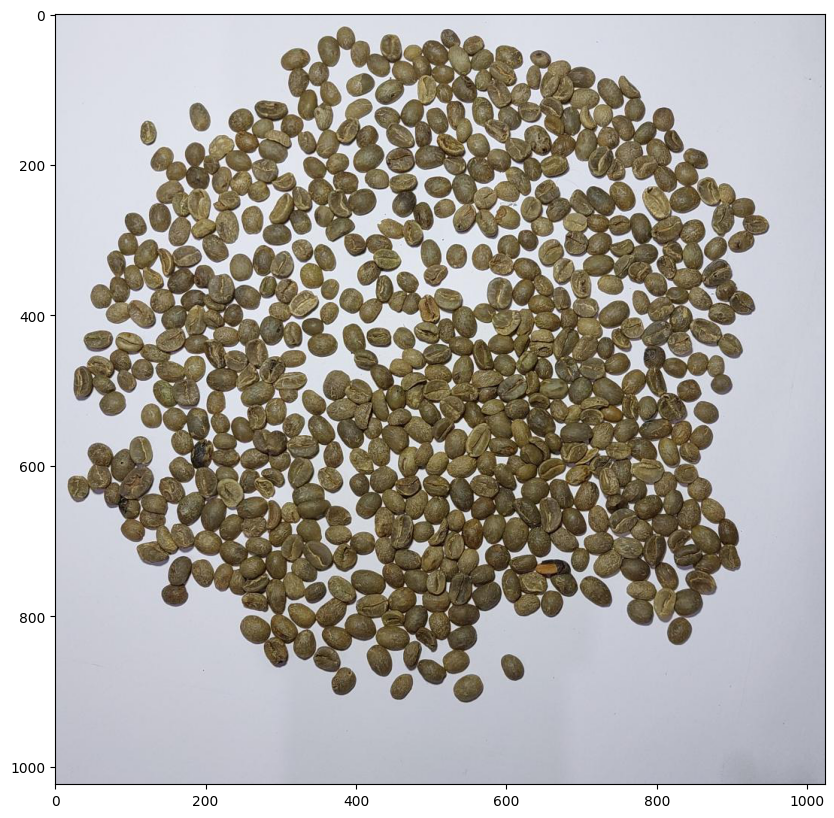

In [25]:
# Let's take a look at the dataset image
img = mmcv.imread('manual_dataset/images/30_1_jpg.rf.279dee5e9aff19d260c2156556bef6b1.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [26]:
# Check the label of a single image
!cat manual_dataset/train/30_1_jpg.rf.279dee5e9aff19d260c2156556bef6b1.txt

181 565 210.5 565 210.5 603.5 181 603.5 hitam 0
85 644 114.5 644 114.5 672 85 672 hitam-sebagian 0
639 724 686.5 724 686.5 749 639 749 kulit-kopi-kecil 0
784 441 811.5 441 811.5 471.5 784 471.5 hitam-sebagian 0

## Config Oriented RCNN (Tutorial)

In [11]:
cfg = Config.fromfile('./configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py')

In [13]:
# Modify dataset type and path
cfg.dataset_type = 'CoffeeDataset'
cfg.data_root = 'manual_dataset/'

cfg.data.test.type = 'CoffeeDataset'
cfg.data.test.data_root = 'manual_dataset/'
cfg.data.test.ann_file = 'val'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'CoffeeDataset'
cfg.data.train.data_root = 'manual_dataset/'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'CoffeeDataset'
cfg.data.val.data_root = 'manual_dataset/'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'pretrained/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 5
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CoffeeDataset'
data_root = 'manual_dataset/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='RResize'),
            dict(
               

In [ ]:
# Hapus log training sebelumnya
!rm -rf tutorial_exps

In [14]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2024-12-30 23:34:06,210 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-12-30 23:34:06,218 - mmdet - INFO - load checkpoint from local path: pretrained/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
2024-12-30 23:34:07,181 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([16, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([4]).
2024-12-30 23:34:07,183 - mmdet - INFO - Start running, host: abiyamf@Abiya, work_dir: /home/abiyamf/Large-Selective-Kernel-Network/tutorial_exps
2024-12-30 23:34:07,184 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook             

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.0 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:36:09,257 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 3042 | 1.000  | 0.544 |
| hitam-sebagian   | 50  | 1883 | 0.900  | 0.086 |
| kulit-kopi-kecil | 35  | 1371 | 0.714  | 0.148 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.259 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.7 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:38:17,838 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 431  | 0.962  | 0.665 |
| hitam-sebagian   | 50  | 493  | 0.780  | 0.248 |
| kulit-kopi-kecil | 35  | 510  | 0.914  | 0.802 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.572 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.9 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:40:23,112 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 527  | 0.981  | 0.737 |
| hitam-sebagian   | 50  | 898  | 0.960  | 0.392 |
| kulit-kopi-kecil | 35  | 616  | 0.914  | 0.856 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.662 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.2 task/s, elapsed: 8s, ETA:     0s

2024-12-30 23:42:29,287 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 390  | 0.962  | 0.772 |
| hitam-sebagian   | 50  | 539  | 0.960  | 0.486 |
| kulit-kopi-kecil | 35  | 356  | 0.943  | 0.893 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.717 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.9 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:44:32,963 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 444  | 0.981  | 0.800 |
| hitam-sebagian   | 50  | 867  | 1.000  | 0.582 |
| kulit-kopi-kecil | 35  | 360  | 0.971  | 0.886 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.756 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.9 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:46:39,296 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 423  | 0.981  | 0.820 |
| hitam-sebagian   | 50  | 675  | 0.980  | 0.632 |
| kulit-kopi-kecil | 35  | 297  | 0.971  | 0.906 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.786 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.9 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:48:43,795 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 343  | 0.981  | 0.825 |
| hitam-sebagian   | 50  | 566  | 0.960  | 0.660 |
| kulit-kopi-kecil | 35  | 316  | 0.943  | 0.901 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.796 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.9 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:50:47,757 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 340  | 0.981  | 0.823 |
| hitam-sebagian   | 50  | 563  | 0.980  | 0.703 |
| kulit-kopi-kecil | 35  | 211  | 0.971  | 0.897 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.808 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.0 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:52:52,122 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 359  | 0.981  | 0.830 |
| hitam-sebagian   | 50  | 547  | 0.980  | 0.710 |
| kulit-kopi-kecil | 35  | 235  | 0.971  | 0.906 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.815 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.9 task/s, elapsed: 7s, ETA:     0s

2024-12-30 23:54:59,121 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 364  | 0.981  | 0.828 |
| hitam-sebagian   | 50  | 528  | 0.960  | 0.689 |
| kulit-kopi-kecil | 35  | 247  | 0.971  | 0.906 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.808 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

In [16]:
# load tensorboard
%reload_ext tensorboard

# Menampilkan grafik training
%tensorboard --logdir ./tutorial_exps/tf_logs

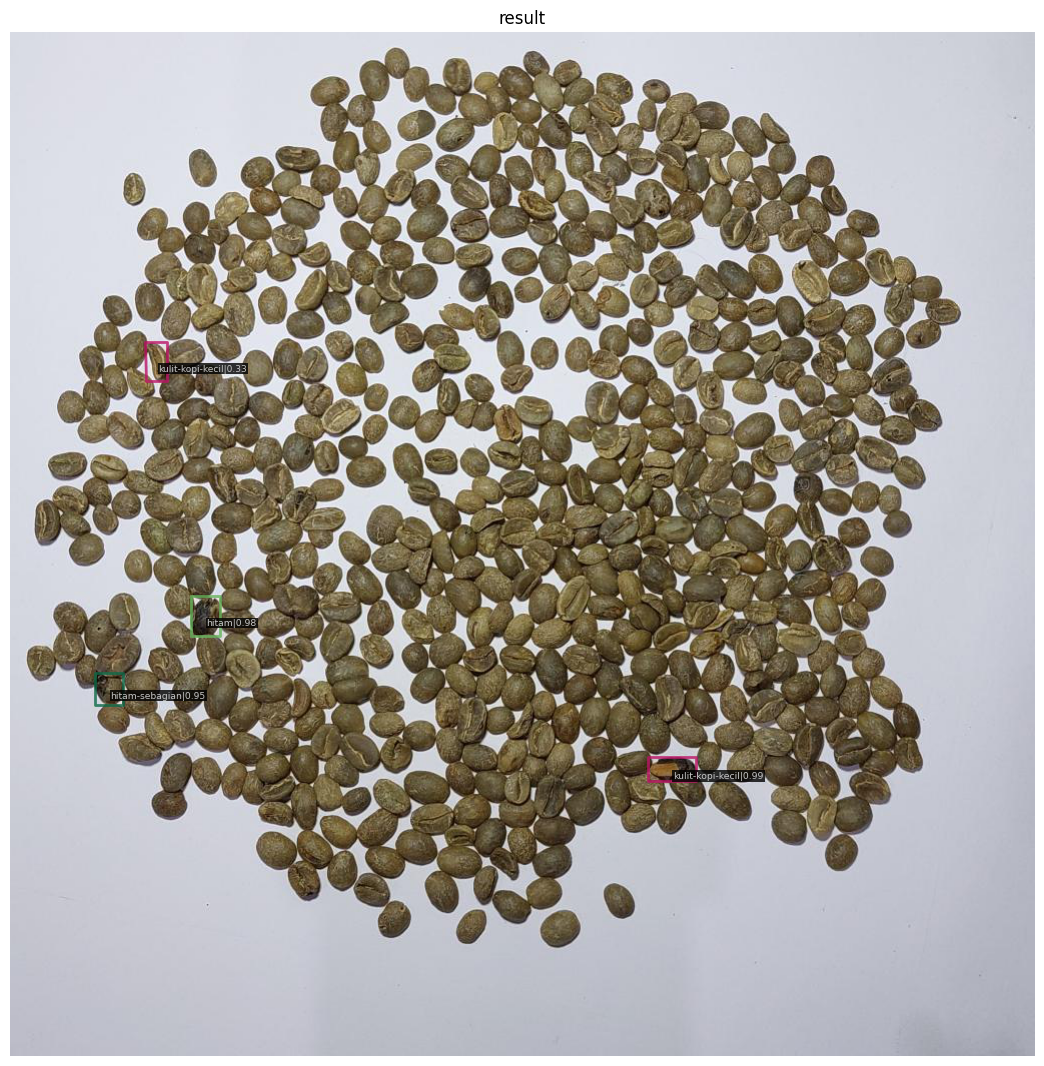

In [15]:
img = mmcv.imread('manual_dataset/images/30_1_jpg.rf.279dee5e9aff19d260c2156556bef6b1.png')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

# Simpan hasil ke file
output_file = 'output_result.png'  # Nama file output
model.show_result(img, result, score_thr=0.3, out_file=output_file)

In [16]:
# Folder input dan output
input_folder = 'manual_dataset/images'
output_folder = 'hasil_predict/config_tutorial'

# Pastikan folder output ada
os.makedirs(output_folder, exist_ok=True)

# Ambil semua file gambar di folder input
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pilih 10 gambar secara acak
random_images = random.sample(image_files, min(10, len(image_files)))

# Prediksi dan simpan hasilnya
for img_name in random_images:
    # Path lengkap untuk gambar input dan output
    input_path = os.path.join(input_folder, img_name)
    output_path = os.path.join(output_folder, f'pred_{img_name}')

    # Baca gambar
    img = mmcv.imread(input_path)

    # Lakukan prediksi
    result = inference_detector(model, img)

    # Simpan hasil prediksi
    model.show_result(img, result, score_thr=0.3, out_file=output_path)

    print(f"Hasil prediksi disimpan: {output_path}")

print("Prediksi selesai untuk 10 gambar acak.")

Hasil prediksi disimpan: hasil_predict/pred_30_254_jpg.rf.f224042101a165598937857e82935abb.png
Hasil prediksi disimpan: hasil_predict/pred_40_101_jpg.rf.7c5870b10792fcdf4d780baa2d62d9f2.png
Hasil prediksi disimpan: hasil_predict/pred_30_232_jpg.rf.35050409c019428f058a9a25851ad269.png
Hasil prediksi disimpan: hasil_predict/pred_30_289_jpg.rf.5ff50c5dab2af53664c2992919e90108.png
Hasil prediksi disimpan: hasil_predict/pred_30_273_jpg.rf.8be2d7b0760a2140cccf7d168044b1e9.png
Hasil prediksi disimpan: hasil_predict/pred_30_179_jpg.rf.24d82fd404ae9cbc7a9ed190b4e5be00.png
Hasil prediksi disimpan: hasil_predict/pred_30_50_jpg.rf.1a81e397fc103631701097789312d986.png
Hasil prediksi disimpan: hasil_predict/pred_30_194_jpg.rf.4ef372ec1d684b1c3c30a11a42d6f81d.png
Hasil prediksi disimpan: hasil_predict/pred_40_102_jpg.rf.3acdf48d7b1e7164bd6ffb96cee5d55a.png
Hasil prediksi disimpan: hasil_predict/pred_30_38_jpg.rf.53fab8674139f06029e59797cfff239d.png
Prediksi selesai untuk 10 gambar acak.


## Config LSKNet-T

In [36]:
cfg = Config.fromfile('./configs/lsknet/lsk_t_fpn_1x_dota_le90.py')

In [37]:
# Modify dataset type and path
cfg.dataset_type = 'CoffeeDataset'
cfg.data_root = 'manual_dataset/'

cfg.data.test.type = 'CoffeeDataset'
cfg.data.test.data_root = 'manual_dataset/'
cfg.data.test.ann_file = 'val'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'CoffeeDataset'
cfg.data.train.data_root = 'manual_dataset/'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'CoffeeDataset'
cfg.data.val.data_root = 'manual_dataset/'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

# Pre trained lskNet-S
cfg.load_from = 'pretrained/lsk_t_fpn_1x_dota_le90_20230206-3ccee254.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 10
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CoffeeDataset'
data_root = 'manual_dataset/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='PolyRandomRotate',
        rotate_ratio=0.5,
        angles_range=180,
        auto_bound=False,
        rect_classes=[9, 11],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict

In [ ]:
# Hapus log training sebelumnya
!rm -rf tutorial_exps

In [38]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2024-12-31 00:30:41,588 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-12-31 00:30:41,595 - mmdet - INFO - load checkpoint from local path: pretrained/lsk_t_fpn_1x_dota_le90_20230206-3ccee254.pth
2024-12-31 00:30:41,729 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([16, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([4]).
2024-12-31 00:30:41,731 - mmdet - INFO - Start running, host: abiyamf@Abiya, work_dir: /home/abiyamf/Large-Selective-Kernel-Network/tutorial_exps
2024-12-31 00:30:41,732 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.6 task/s, elapsed: 7s, ETA:     0s

2024-12-31 00:34:41,146 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 472  | 1.000  | 0.830 |
| hitam-sebagian   | 50  | 474  | 0.960  | 0.625 |
| kulit-kopi-kecil | 35  | 341  | 1.000  | 0.895 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.783 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.2 task/s, elapsed: 6s, ETA:     0s

2024-12-31 00:38:32,396 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 274  | 0.942  | 0.825 |
| hitam-sebagian   | 50  | 361  | 0.900  | 0.645 |
| kulit-kopi-kecil | 35  | 129  | 0.943  | 0.899 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.790 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.9 task/s, elapsed: 7s, ETA:     0s

2024-12-31 00:42:23,774 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 327  | 0.981  | 0.855 |
| hitam-sebagian   | 50  | 450  | 0.940  | 0.685 |
| kulit-kopi-kecil | 35  | 86   | 0.914  | 0.897 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.812 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.3 task/s, elapsed: 6s, ETA:     0s

2024-12-31 00:46:23,100 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 127  | 0.904  | 0.833 |
| hitam-sebagian   | 50  | 139  | 0.900  | 0.736 |
| kulit-kopi-kecil | 35  | 79   | 0.943  | 0.909 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.826 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.8 task/s, elapsed: 7s, ETA:     0s

2024-12-31 00:50:08,951 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 255  | 0.962  | 0.873 |
| hitam-sebagian   | 50  | 715  | 0.980  | 0.765 |
| kulit-kopi-kecil | 35  | 210  | 0.971  | 0.906 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.848 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 4.8 task/s, elapsed: 8s, ETA:     0s

2024-12-31 00:53:59,205 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 356  | 0.962  | 0.872 |
| hitam-sebagian   | 50  | 385  | 0.960  | 0.698 |
| kulit-kopi-kecil | 35  | 178  | 0.971  | 0.909 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.826 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.2 task/s, elapsed: 6s, ETA:     0s

2024-12-31 00:57:58,210 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 165  | 0.962  | 0.853 |
| hitam-sebagian   | 50  | 233  | 0.980  | 0.756 |
| kulit-kopi-kecil | 35  | 41   | 0.914  | 0.906 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.838 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.1 task/s, elapsed: 8s, ETA:     0s

2024-12-31 01:02:03,979 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 91   | 0.750  | 0.666 |
| hitam-sebagian   | 50  | 100  | 0.620  | 0.418 |
| kulit-kopi-kecil | 35  | 244  | 0.886  | 0.772 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.619 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.0 task/s, elapsed: 7s, ETA:     0s

2024-12-31 01:06:24,366 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 290  | 0.962  | 0.860 |
| hitam-sebagian   | 50  | 408  | 0.980  | 0.729 |
| kulit-kopi-kecil | 35  | 147  | 0.914  | 0.909 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.832 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.1 task/s, elapsed: 7s, ETA:     0s

2024-12-31 01:10:30,069 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 184  | 0.962  | 0.872 |
| hitam-sebagian   | 50  | 195  | 0.980  | 0.797 |
| kulit-kopi-kecil | 35  | 102  | 0.914  | 0.909 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.859 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

In [ ]:
# load tensorboard
%reload_ext tensorboard

# Menampilkan grafik training
%tensorboard --logdir ./tutorial_exps/tf_logs

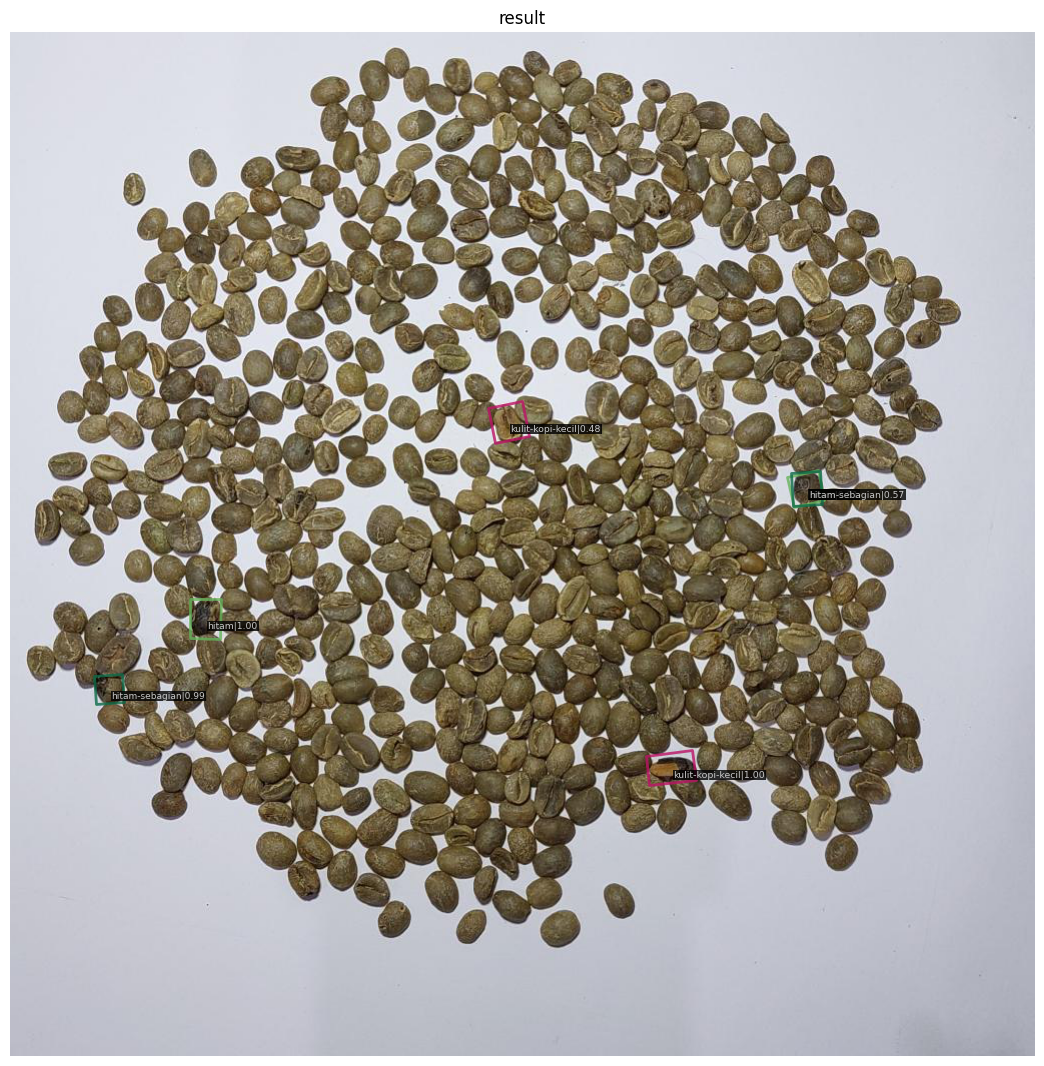

In [39]:
from mmdet.apis import inference_detector, show_result_pyplot

img = mmcv.imread('manual_dataset/images/30_1_jpg.rf.279dee5e9aff19d260c2156556bef6b1.png')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

# Simpan hasil ke file
output_file = 'output_result.png'  # Nama file output
model.show_result(img, result, score_thr=0.3, out_file=output_file)

In [40]:

# Folder input dan output
input_folder = 'manual_dataset/images'
output_folder = 'hasil_predict/config_LSKNet-T'

# Pastikan folder output ada
os.makedirs(output_folder, exist_ok=True)

# Ambil semua file gambar di folder input
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pilih 10 gambar secara acak
random_images = random.sample(image_files, min(10, len(image_files)))

# Prediksi dan simpan hasilnya
for img_name in random_images:
    # Path lengkap untuk gambar input dan output
    input_path = os.path.join(input_folder, img_name)
    output_path = os.path.join(output_folder, f'pred_{img_name}')

    # Baca gambar
    img = mmcv.imread(input_path)

    # Lakukan prediksi
    result = inference_detector(model, img)

    # Simpan hasil prediksi
    model.show_result(img, result, score_thr=0.3, out_file=output_path)

    print(f"Hasil prediksi disimpan: {output_path}")

print("Prediksi selesai untuk 10 gambar acak.")

Hasil prediksi disimpan: hasil_predict/pred_30_254_jpg.rf.f224042101a165598937857e82935abb.png
Hasil prediksi disimpan: hasil_predict/pred_40_101_jpg.rf.7c5870b10792fcdf4d780baa2d62d9f2.png
Hasil prediksi disimpan: hasil_predict/pred_30_232_jpg.rf.35050409c019428f058a9a25851ad269.png
Hasil prediksi disimpan: hasil_predict/pred_30_289_jpg.rf.5ff50c5dab2af53664c2992919e90108.png
Hasil prediksi disimpan: hasil_predict/pred_30_273_jpg.rf.8be2d7b0760a2140cccf7d168044b1e9.png
Hasil prediksi disimpan: hasil_predict/pred_30_179_jpg.rf.24d82fd404ae9cbc7a9ed190b4e5be00.png
Hasil prediksi disimpan: hasil_predict/pred_30_50_jpg.rf.1a81e397fc103631701097789312d986.png
Hasil prediksi disimpan: hasil_predict/pred_30_194_jpg.rf.4ef372ec1d684b1c3c30a11a42d6f81d.png
Hasil prediksi disimpan: hasil_predict/pred_40_102_jpg.rf.3acdf48d7b1e7164bd6ffb96cee5d55a.png
Hasil prediksi disimpan: hasil_predict/pred_30_38_jpg.rf.53fab8674139f06029e59797cfff239d.png
Prediksi selesai untuk 10 gambar acak.


## Config LSKNet-S

In [18]:
cfg = Config.fromfile('./configs/lsknet/lsk_s_ema_fpn_1x_dota_le90.py')

In [19]:
# Modify dataset type and path
cfg.dataset_type = 'CoffeeDataset'
cfg.data_root = 'manual_dataset/'

cfg.data.test.type = 'CoffeeDataset'
cfg.data.test.data_root = 'manual_dataset/'
cfg.data.test.ann_file = 'val'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'CoffeeDataset'
cfg.data.train.data_root = 'manual_dataset/'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'CoffeeDataset'
cfg.data.val.data_root = 'manual_dataset/'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

# Pre trained lskNet-S
cfg.load_from = 'pretrained/lsk_s_ema_fpn_1x_dota_le90_20230212-30ed4041.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 5
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CoffeeDataset'
data_root = 'manual_dataset/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='PolyRandomRotate',
        rotate_ratio=0.5,
        angles_range=180,
        auto_bound=False,
        rect_classes=[9, 11],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict

In [ ]:
# Hapus log training sebelumnya
!rm -rf tutorial_exps

In [20]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2024-12-31 13:58:28,668 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-12-31 13:58:28,676 - mmdet - INFO - load checkpoint from local path: pretrained/lsk_s_ema_fpn_1x_dota_le90_20230212-30ed4041.pth
2024-12-31 13:58:29,141 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([16, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([4]).
unexpected key in source state_dict: ema_backbone_patch_embed1_proj_weight, ema_backbone_patch_embed1_proj_bias, ema_backbone_patch_embed1_norm_weight, ema_backbone_patch_embed1_norm_bias, ema_backbone_patch_embed1_norm_running_mean, ema_backbone_patch_embed1_norm_running_var, ema_backbone_patch_embed1_norm_num_batches_tracked, ema_back

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 6.0 task/s, elapsed: 7s, ETA:     0s

2024-12-31 14:02:00,021 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 31   | 0.327  | 0.262 |
| hitam-sebagian   | 50  | 43   | 0.200  | 0.081 |
| kulit-kopi-kecil | 35  | 19   | 0.429  | 0.455 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.266 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.4 task/s, elapsed: 7s, ETA:     0s

2024-12-31 14:05:39,235 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 215  | 0.962  | 0.757 |
| hitam-sebagian   | 50  | 343  | 0.960  | 0.635 |
| kulit-kopi-kecil | 35  | 160  | 0.886  | 0.765 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.719 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.1 task/s, elapsed: 8s, ETA:     0s

2024-12-31 14:09:21,343 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 112  | 0.827  | 0.724 |
| hitam-sebagian   | 50  | 118  | 0.720  | 0.541 |
| kulit-kopi-kecil | 35  | 55   | 0.714  | 0.727 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.664 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.5 task/s, elapsed: 7s, ETA:     0s

2024-12-31 14:12:57,380 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 0    | 0.000  | 0.000 |
| hitam-sebagian   | 50  | 0    | 0.000  | 0.000 |
| kulit-kopi-kecil | 35  | 0    | 0.000  | 0.000 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.000 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 40/40, 5.5 task/s, elapsed: 7s, ETA:     0s

2024-12-31 14:16:27,354 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| hitam            | 52  | 0    | 0.000  | 0.000 |
| hitam-sebagian   | 50  | 0    | 0.000  | 0.000 |
| kulit-kopi-kecil | 35  | 0    | 0.000  | 0.000 |
+------------------+-----+------+--------+-------+
| mAP              |     |      |        | 0.000 |
+------------------+-----+------+--------+-------+
/home/abiyamf/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/abiyamf/anaconda3/envs/openmmlab/lib/python

In [ ]:
# load tensorboard
%reload_ext tensorboard

# Menampilkan grafik training
%tensorboard --logdir ./tutorial_exps/tf_logs

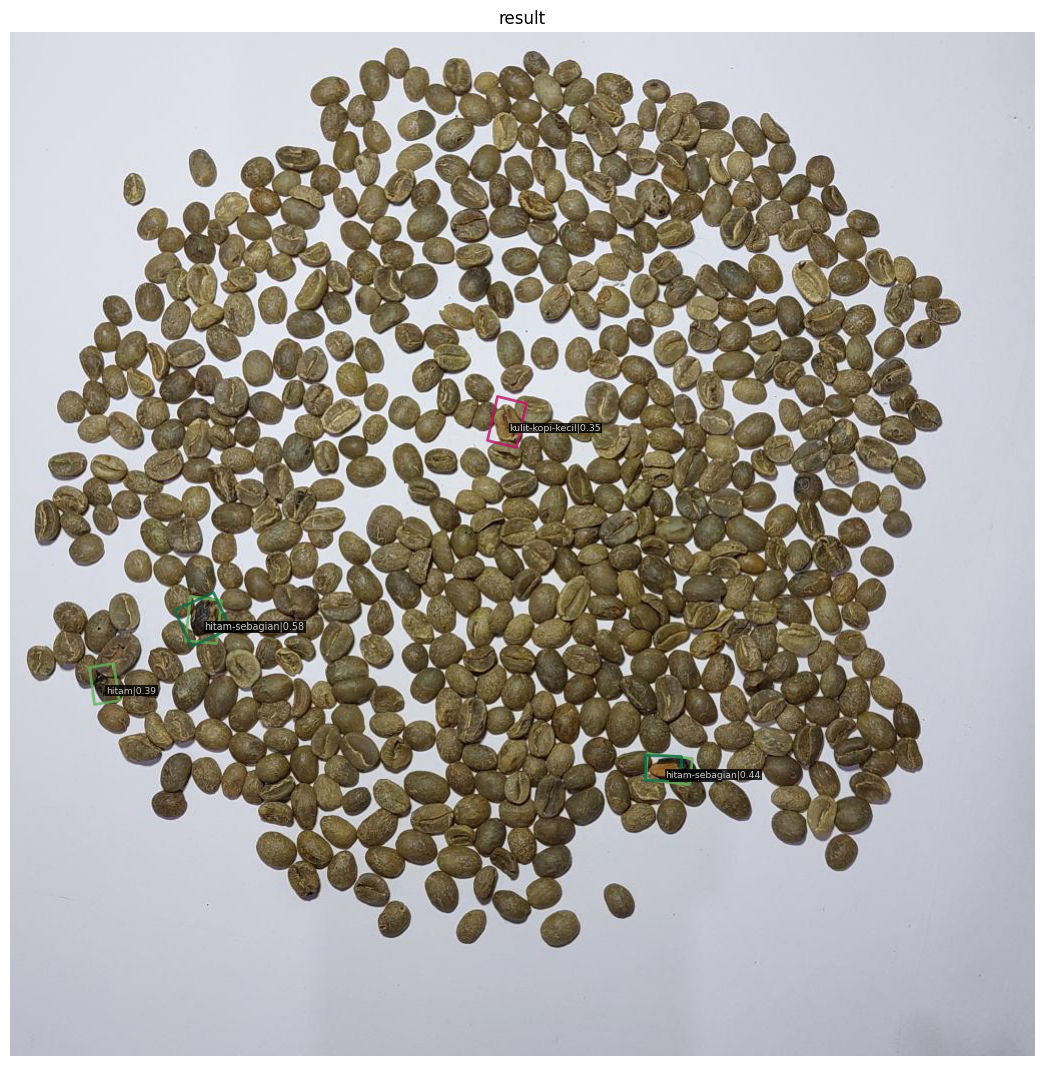

In [17]:
img = mmcv.imread('manual_dataset/images/30_1_jpg.rf.279dee5e9aff19d260c2156556bef6b1.png')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

# Simpan hasil ke file
output_file = 'output_result.png'  # Nama file output
model.show_result(img, result, score_thr=0.3, out_file=output_file)

In [ ]:
# Folder input dan output
input_folder = 'manual_dataset/images'
output_folder = 'hasil_predict/LSKNet-S'

# Pastikan folder output ada
os.makedirs(output_folder, exist_ok=True)

# Ambil semua file gambar di folder input
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pilih 10 gambar secara acak
random_images = random.sample(image_files, min(10, len(image_files)))

# Prediksi dan simpan hasilnya
for img_name in random_images:
    # Path lengkap untuk gambar input dan output
    input_path = os.path.join(input_folder, img_name)
    output_path = os.path.join(output_folder, f'pred_{img_name}')

    # Baca gambar
    img = mmcv.imread(input_path)

    # Lakukan prediksi
    result = inference_detector(model, img)

    # Simpan hasil prediksi
    model.show_result(img, result, score_thr=0.3, out_file=output_path)

    print(f"Hasil prediksi disimpan: {output_path}")

print("Prediksi selesai untuk 10 gambar acak.")